# OpenImagesV4 Data Preparation Utility For YOLOV3

This module extracts images from the Open Images Dataset V4 that contain selected classes, generating a corresponding .txt or .xml file for each image as per the YOLO and PASCAL VOC annotation formats respectively and the necessary metadata files.

You will need these libraries:
    1. pandas
    2. pascal_voc_writer
    3. pillow
    4. seaborn
    5. tqdm
    
You require the following meta files, located in a single directory:
    1. class_descriptions.csv
    2. train_annotations.csv
    3. train_images_with_rotation.csv
    4. valid_annotations.csv
    5. valid_images.csv
    
Subsequently, specify the source and destination paths accordingly, in the dictionaries:
    1. src
    2. dest

Finally, indicate the output annotation format, as either:
    1. "YOLO" or 
    2. "PASCALVOC"

Your selected classes are stored as a list of class descriptions (case-sensitive) - add to or remove from it as needed. 

Optionally, you can limit the number of training and validation images copied by setting:
    1. limit
    2. n
    
Both training and validation images will be copied into a folder named 'custom', and the generated metadata files are:
    1. custom.names - contains class descriptions
    2. train.txt - contains relative paths from darknet.exe to every trainin image
    3. valid.txt - contains relative paths from darknet.exe to every validation image
    
    i.e. data/custom/XXX.jpg
    
Your directory tree should look like this:

```
|-- darknet
|   |-- data
|   |   |-- custom
|   |   |   |-- XXX.jpg
|   |   |   |-- XXX.txt
|   |   |   |-- YYY.jpg
|   |   |   |-- YYY.txt
|   |   |   ...
|   |   |-- custom.names
|   |   |-- train.txt
|   |   |-- validation.txt
|   ...
```

In [11]:
from pascal_voc_writer import Writer
from PIL import Image
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

In [27]:
classes = [
    "Person",
    "Human face",
    "Hat",
    "Sunglasses",
    "Knife",
    "Handgun",
    "Rifle",
    # "Weapon",
    "Jacket",
    # "Shorts",
    # "Jeans",
    # "Skirt",
]

src = {"train": "/media/tingyu/WD BLUE/open_images/all/train_0", 
       "valid": "/media/tingyu/WD BLUE/open_images/all/validation", 
       "meta": "/media/tingyu/WD BLUE/open_images/all/meta"}
dest = "{}/data".format(os.getcwd())

annotation_format = "YOLO"

limit = {"train": True, 
         "valid": True}
n = {"train": 100, 
     "valid": 25}

In [33]:
class OpenImagesUtility():
    def __init__(self, classes, src, dest, annotation_format, limit, n):
        self.src = src
        self.dest = dest
        self.annotation_format = annotation_format
        self.limit = limit
        self.n = n
        
        self.class_desc = pd.read_csv("{}/class_descriptions.csv".format(self.src["meta"]), header=None)
        self.class_desc.columns = ["LabelName", "Description"]
        label_names = [self.class_desc[self.class_desc["Description"] == c]["LabelName"].values[0]
                       for c in classes]
        """
        select LabelName, Description
        from   class_desc
        where  LabelName in label_names
        """
        self.class_desc = (self.class_desc[self.class_desc["LabelName"].isin(label_names)][["LabelName", "Description"]]
                           .sort_values(["Description"]))
        self.class_desc = self.class_desc.reset_index(drop=True)
        print("Total Classes: {}".format(self.class_desc.shape[0]))
        
        train_annotations = pd.read_csv("{}/train_annotations.csv".format(self.src["meta"]))
        """
        select *
        from   train_annotations join class_desc
               on LabelName
        """
        train_annotations = (pd.merge(train_annotations, self.class_desc, on="LabelName")
                             .sort_values(["ImageID"]))
        print("Total Training Annotations: {}".format(train_annotations.shape[0]))
        
        train_imgs = pd.read_csv("{}/train_images_with_rotation.csv".format(self.src["meta"]))
        """
        select *
        from   train_imgs join (select distinct ImageID from train_annotations) 
               on ImageID
        """
        train_imgs = (pd.merge(train_imgs, pd.DataFrame(train_annotations["ImageID"].unique(), columns=["ImageID"]), on="ImageID")
                      .sort_values(["ImageID"]))
        print("Total Training Images: {}".format(train_imgs.shape[0]))
        
        valid_annotations = pd.read_csv("{}/valid_annotations.csv".format(self.src["meta"]))
        """
        select *
        from   valid_annotations join class_desc
               on LabelName
        """
        valid_annotations = (pd.merge(valid_annotations, self.class_desc, on="LabelName")
                             .sort_values(["ImageID"]))
        print("Total Validation Annotations: {}".format(valid_annotations.shape[0]))
        
        valid_imgs = pd.read_csv("{}/valid_images.csv".format(self.src["meta"]))
        valid_imgs["ImageID"] = valid_imgs["ImageID"].apply(lambda s: s[0:len(s) - 4])
        """
        select *
        from   valid_images join (select distinct ImageID from valid_annotations) 
               on ImageID
        """
        valid_imgs = (pd.merge(valid_imgs, pd.DataFrame(valid_annotations["ImageID"].unique(), columns=["ImageID"]), on="ImageID")
                      .sort_values(["ImageID"]))
        print("Total Validation Images: {}".format(valid_imgs.shape[0]))
        
        self.annotations = {"train": train_annotations, 
                            "valid": valid_annotations}
        self.imgs = {"train": train_imgs, 
                     "valid": valid_imgs}
        
    def _to_yolo_format(self, label_name, x_min, x_max, y_min, y_max):
        label_idx = self.get_label_idx(label_name)
        x_mid = (x_min + x_max) / 2
        y_mid = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min
        return "{} {} {} {} {}".format(label_idx, x_mid, y_mid, width, height)

    def _mk_annotations_txt(self, annotations, folder_path, img_id):
        with open("{}/{}.txt".format(folder_path, img_id), "w+") as file:    
            file.write("\n".join([self._to_yolo_format(r["LabelName"], r["XMin"], r["XMax"], r["YMin"], r["YMax"]) 
                                  for _, r in annotations.iterrows()]))
            file.close()

    def _mk_annotations_xml(self, annotations, folder_path, img_id):
        img = Image.open("{}/{}.jpg".format(folder_path, img_id))
        width, height = img.size
        writer = Writer(img_path, width, height)
        for _, r in annotations.iterrows():
            label_desc = self.get_label_desc(r["LabelName"])
            x_min = round(r["XMin"] * width)
            x_max = round(r["XMax"] * width)
            y_min = round(r["YMin"] * height)
            y_max = round(r["YMax"] * height)
            writer.addObject(label_desc, x_min, x_max, y_min, y_max)
        writer.save("{}/{}.xml".format(folder_path, img_id))

    def _mk_annotations_file(self, annotations, folder_path, img_id):
        if self.annotation_format == "YOLO":
            self._mk_annotations_txt(annotations, folder_path, img_id)
        elif self.annotation_format == "PASCALVOC":
            self._mk_annotations_xml(annotations, folder_path, img_id)
        else:
            raise ValueError("Invalid annotation format")
    
    def _cp_with_annotations(self, imgs, annotations, src, limit, n):
        if not limit: 
            n = imgs.shape[0] 
        paths = []
        logs = []
        with tqdm(total=n) as pbar:
            for _, r in imgs.iterrows():
                if limit and len(paths) == n: 
                    break
                try:
                    copyfile("{}/{}.jpg".format(src, r["ImageID"]), 
                             "{}/custom/{}.jpg".format(self.dest, r["ImageID"]))
                    self._mk_annotations_file(annotations[annotations["ImageID"] == r["ImageID"]],
                                              "{}/custom".format(self.dest), 
                                              r["ImageID"])
                    paths.append("data/custom/{}.jpg".format(r["ImageID"]))
                except FileNotFoundError:
                    logs.append("{}.jpg not found".format(r["ImageID"]))
                pbar.update()
        return paths, logs
    
    def get_label_desc(self, label_name):
        return self.class_desc[self.class_desc["LabelName"] == label_name]["Description"].values[0]

    def get_label_idx(self, label_name):
        return self.class_desc[self.class_desc["LabelName"] == label_name].index[0]
    
    def plt_annotations_dist(self, mode):
        dist = (self.annotations[mode]
                .groupby(["LabelName"])
                .size()
                .reset_index(name="Count")
                .sort_values(["Count"]))
        dist["LabelName"] = dist["LabelName"].apply(self.get_label_desc)
        plt.barh(y=dist["LabelName"], width=dist["Count"])
        plt.show()
        
    def mk_dest_dirs(self):
        if not os.path.exists(self.dest): os.mkdir(self.dest)
        if not os.path.exists("{}/custom".format(self.dest)):
            os.mkdir("{}/custom".format(self.dest))
            
    def mk_yolo_metas(self):
        with open("{}/custom.names".format(self.dest), "w+") as names_file:
            names_file.write("\n".join(self.class_desc["Description"].tolist()))
            names_file.close()
        with open("{}/custom.data".format(self.dest), "w+") as data_txt:
            data_txt.write("classes={}" \
                           "\ntrain=data/train.txt" \
                           "\nvalid=data/valid.txt" \
                           "\nnames=data/custom.names" \
                           "\nbackup=backup"
                           .format(self.class_desc.shape[0]))
            data_txt.close()
        
    def prep(self, mode):
        paths, logs = self._cp_with_annotations(self.imgs[mode], 
                                                self.annotations[mode], 
                                                self.src[mode], 
                                                self.limit[mode], 
                                                self.n[mode])
        with open("{}/{}.txt".format(self.dest, mode), "w+") as txt:
            txt.write("\n".join(paths))
            txt.close()
        return logs
        
    def start(self):
        self.mk_dest_dirs()
        self.mk_yolo_metas()
        self.prep("train")
        self.prep("valid")

In [34]:
utility = OpenImagesUtility(classes, src, dest, annotation_format, limit, n)

Total Classes: 12
Total Training Annotations: 2239419
Total Training Images: 574760
Total Validation Annotations: 19806
Total Validation Images: 8501


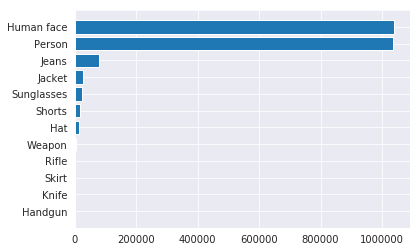

In [30]:
utility.plt_annotations_dist("train")

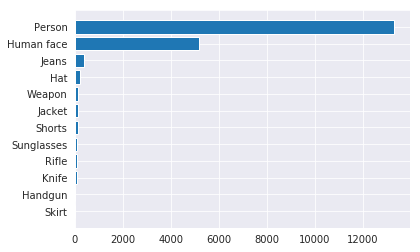

In [31]:
utility.plt_annotations_dist("valid")

In [26]:
utility.start()

100%|██████████| 25/25 [00:00<00:00, 176.56it/s]
